Epoch: 0, Loss: 0.6991937160491943
Epoch: 0, Loss: 0.6924907565116882
Epoch: 0, Loss: 0.6820937991142273
Epoch: 0, Loss: 0.6667574048042297
Epoch: 0, Loss: 0.6416953802108765
Epoch: 0, Loss: 0.6145088076591492
Epoch: 0, Loss: 0.6036128401756287
Epoch: 0, Loss: 0.5778195858001709
Epoch: 0, Loss: 0.5298896431922913
Epoch: 0, Loss: 0.5252277255058289
Epoch: 0, Loss: 0.4747220277786255
Epoch: 0, Loss: 0.44836583733558655
Epoch: 0, Loss: 0.3774696886539459
Epoch: 0, Loss: 0.33445224165916443
Epoch: 0, Loss: 0.33386144042015076
Epoch: 0, Loss: 0.2507418394088745
Epoch: 0, Loss: 0.24528977274894714
Epoch: 0, Loss: 0.1803014874458313
Epoch: 0, Loss: 0.09887613356113434
Epoch: 0, Loss: 0.09713342785835266
Epoch: 0, Loss: 0.043914299458265305
Epoch: 0, Loss: 0.042648617178201675
Epoch: 0, Loss: 0.03201794996857643
Epoch: 0, Loss: 0.047999680042266846
Epoch: 0, Loss: 0.005960051901638508
Epoch: 0, Loss: 0.0034313455689698458
Epoch: 0, Loss: 0.003942613489925861
Epoch: 0, Loss: 0.00332966446876525

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

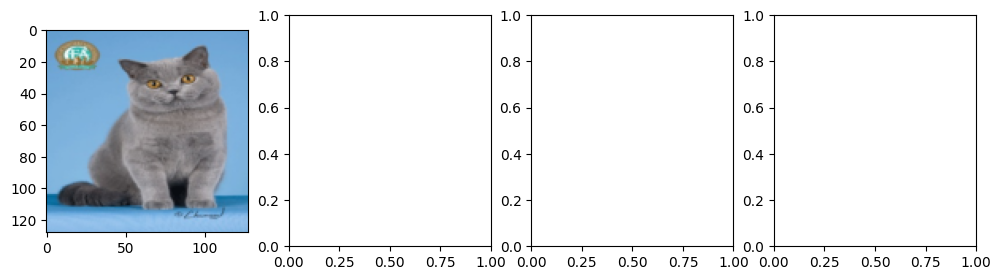

In [5]:
import os
from bs4 import BeautifulSoup
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torch.nn.functional as F

# Disable cuDNN benchmark
import torch.backends.cudnn as cudnn
cudnn.benchmark = False

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

# Custom dataset class
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        original_w, original_h = annots[0][6], annots[0][7]
        for annot in annots:
            xmin = annot[2] * 128 / original_w
            ymin = annot[3] * 128 / original_h
            xmax = annot[4] * 128 / original_w
            ymax = annot[5] * 128 / original_h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Transformation function
def get_transform(train):
    transforms = []
    transforms.append(T.Resize((128, 128)))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Load annotations
annotations = read_ann('./data/annotations')

# Initialize dataset and dataloader
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Define the custom Faster R-CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors * 2, kernel_size=1, stride=1)  # Binary classification
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1, stride=1)   # Bounding box regression

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

class RoIPool(nn.Module):
    def __init__(self, output_size):
        super(RoIPool, self).__init__()
        self.output_size = output_size

    def forward(self, feature_map, proposals_batch):
        pooled_features = []
        _, _, H, W = feature_map.size()
        for proposals in proposals_batch:
            for proposal in proposals:
                x1, y1, x2, y2 = proposal.int()  # Convert to int
                x1, y1 = max(0, x1), max(0, y1)  # Ensure within bounds
                x2, y2 = min(W, x2), min(H, y2)  # Ensure within bounds
                if x2 > x1 and y2 > y1:
                    roi = feature_map[:, :, y1:y2, x1:x2]
                    pooled_feature = F.adaptive_max_pool2d(roi, self.output_size)
                    pooled_features.append(pooled_feature)
        return torch.cat(pooled_features, 0)

class FastRCNNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNHead, self).__init__()
        self.fc1 = nn.Linear(in_channels, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)
        return cls_score, bbox_pred

class SimpleFasterRCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFasterRCNN, self).__init__()
        self.backbone = SimpleCNN()
        self.rpn = RPN(in_channels=256, num_anchors=9)
        self.roi_pool = RoIPool(output_size=(7, 7))
        self.head = FastRCNNHead(in_channels=256 * 7 * 7, num_classes=num_classes)

    def forward(self, images, proposals_batch):
        feature_map = self.backbone(images)
        rpn_logits, rpn_bbox_pred = self.rpn(feature_map)
        
        # Simplified assumption that proposals are given for RoI pooling
        roi_pooled_features = self.roi_pool(feature_map, proposals_batch)
        
        cls_score, bbox_pred = self.head(roi_pooled_features)
        return cls_score, bbox_pred

# Instantiate the model
num_classes = 2  # background and object class
model = SimpleFasterRCNN(num_classes=num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Dummy proposals for simplicity, use actual proposals in practice
        batch_size = images.size(0)
        proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(batch_size)]

        cls_score, bbox_pred = model(images, proposals_batch)

        # Compute losses (simplified, just for demonstration)
        loss_cls = F.cross_entropy(cls_score, torch.tensor([1] * cls_score.size(0), dtype=torch.long, device=device))
        loss_bbox = F.smooth_l1_loss(bbox_pred, torch.zeros_like(bbox_pred))

        loss = loss_cls + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_freq and (epoch % print_freq == 0):
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
            # Implement evaluation metrics if needed
            # For now, just ensure the model runs without errors

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save the model
torch.save(model.state_dict(), 'simple_faster_rcnn_cat_dog.pth')


bbox_pred shape: torch.Size([16, 8])
bbox_pred: tensor([[-1.5343e-03,  6.0136e-04,  1.3256e-03,  8.1662e-04, -4.3242e-03,
          2.7591e-03, -1.9780e-03,  1.9239e-03],
        [ 8.0895e-05,  6.3589e-05, -6.0518e-05,  1.4007e-03, -1.5593e-04,
         -2.4399e-03, -5.3629e-04, -1.7873e-04],
        [-3.3674e-03,  1.2948e-03,  4.0620e-03,  3.1978e-03, -2.5702e-03,
         -4.2278e-05, -2.0378e-03, -1.4207e-04],
        [-1.4531e-03,  5.4314e-04, -5.9668e-04, -2.7069e-04,  4.6251e-04,
         -2.4709e-03, -1.8972e-03,  2.0202e-03],
        [-1.5343e-03,  6.0136e-04,  1.3256e-03,  8.1662e-04, -4.3242e-03,
          2.7591e-03, -1.9780e-03,  1.9239e-03],
        [ 8.0895e-05,  6.3589e-05, -6.0518e-05,  1.4007e-03, -1.5593e-04,
         -2.4399e-03, -5.3629e-04, -1.7873e-04],
        [-3.3674e-03,  1.2948e-03,  4.0620e-03,  3.1978e-03, -2.5702e-03,
         -4.2278e-05, -2.0378e-03, -1.4207e-04],
        [-1.4531e-03,  5.4314e-04, -5.9668e-04, -2.7069e-04,  4.6251e-04,
         -2.4709e

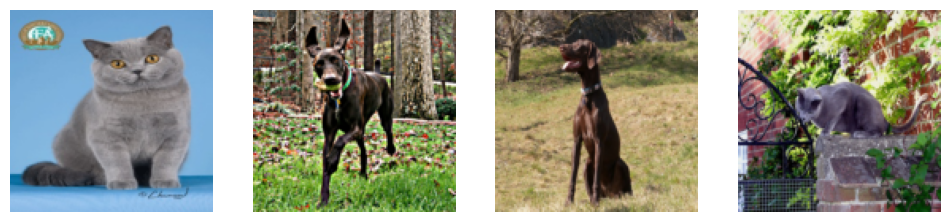

In [11]:
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        # bbox_pred의 형태와 값을 출력
        print(f'bbox_pred shape: {bbox_pred.shape}')
        print(f'bbox_pred: {bbox_pred}')

        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            h, w, _ = img.shape
            # bbox_pred를 반복문에 넣어서 각 박스를 그리도록 합니다.
            if len(bbox_pred.size()) > 1:  # bbox_pred가 0차원 텐서가 아닌 경우만 처리
                for box in bbox_pred[i]:
                    if len(box.size()) == 1 and box.size(0) == 4:  # box가 1차원 텐서이고 크기가 4인 경우만 처리
                        # 예측된 박스 좌표를 이미지 크기에 맞게 조정
                        x1, y1, x2, y2 = box[0].item() * w, box[1].item() * h, box[2].item() * w, box[3].item() * h
                        rect = patches.Rectangle(
                            (x1, y1), x2 - x1, y2 - y1, 
                            linewidth=2, edgecolor='r', facecolor='none'
                        )
                        axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)


In [19]:
import os
from bs4 import BeautifulSoup
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torch.nn.functional as F

# Disable cuDNN benchmark
import torch.backends.cudnn as cudnn
cudnn.benchmark = False

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

# Custom dataset class (with padding and resizing)
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None, shape=(256, 256)):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations
        self.shape = shape

    def __len__(self):
        return len(self.imgs)

    def _preprocess_image(self, img, bbox):
        pad_h, pad_w = 0, 0
        h, w, _ = img.shape
        if h > w:
            pad = int((h - w) / 2)
            pad_w = pad
            img = np.pad(img, ((0, 0), (pad, pad), (0, 0)))
        else:
            pad = int((w - h) / 2)
            pad_h = pad
            img = np.pad(img, ((pad, pad), (0, 0), (0, 0)))

        h, w, _ = img.shape  # 패딩 후의 크기
        img = cv2.resize(img, self.shape)  # 리사이즈
        H, W, _ = img.shape  # 리사이즈 후의 크기
        scale_x, scale_y = w / W, h / H  # 스케일링 비율 계산

        x1, y1, x2, y2 = bbox
        x1, x2 = (x1 + pad_w) / scale_x, (x2 + pad_w) / scale_x
        y1, y2 = (y1 + pad_h) / scale_y, (y2 + pad_h) / scale_y
        return img, (pad_h, pad_w), (x1, y1, x2, y2)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        
        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        for annot in annots:
            xmin = annot[2]
            ymin = annot[3]
            xmax = annot[4]
            ymax = annot[5]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        if len(boxes) > 0:
            img, pads, bbox = self._preprocess_image(img, boxes[0])
            boxes[0] = bbox

        img = (img / 255.).astype(np.float32)
        
        if self.transforms:
            img = Image.fromarray((img * 255).astype(np.uint8))  # To PIL Image
            img = self.transforms(img)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

# Initialize dataset and dataloader with updated transform
annotations = read_ann('./data/annotations')
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)


# Define the custom Faster R-CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors * 2, kernel_size=1, stride=1)  # Binary classification
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1, stride=1)   # Bounding box regression

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

class RoIPool(nn.Module):
    def __init__(self, output_size):
        super(RoIPool, self).__init__()
        self.output_size = output_size

    def forward(self, feature_map, proposals_batch):
        pooled_features = []
        _, _, H, W = feature_map.size()
        for proposals in proposals_batch:
            for proposal in proposals:
                x1, y1, x2, y2 = proposal.int()  # Convert to int
                x1, y1 = max(0, x1), max(0, y1)  # Ensure within bounds
                x2, y2 = min(W, x2), min(H, y2)  # Ensure within bounds
                if x2 > x1 and y2 > y1:
                    roi = feature_map[:, :, y1:y2, x1:x2]
                    pooled_feature = F.adaptive_max_pool2d(roi, self.output_size)
                    pooled_features.append(pooled_feature)
        return torch.cat(pooled_features, 0)

class FastRCNNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNHead, self).__init__()
        self.fc1 = nn.Linear(in_channels, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)
        return cls_score, bbox_pred

class SimpleFasterRCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFasterRCNN, self).__init__()
        self.backbone = SimpleCNN()
        self.rpn = RPN(in_channels=256, num_anchors=9)
        self.roi_pool = RoIPool(output_size=(7, 7))
        self.head = FastRCNNHead(in_channels=256 * 7 * 7, num_classes=num_classes)

    def forward(self, images, proposals_batch):
        feature_map = self.backbone(images)
        rpn_logits, rpn_bbox_pred = self.rpn(feature_map)
        
        # Simplified assumption that proposals are given for RoI pooling
        roi_pooled_features = self.roi_pool(feature_map, proposals_batch)
        
        cls_score, bbox_pred = self.head(roi_pooled_features)
        return cls_score, bbox_pred

# Instantiate the model
num_classes = 2  # background and object class
model = SimpleFasterRCNN(num_classes=num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Dummy proposals for simplicity, use actual proposals in practice
        batch_size = images.size(0)
        proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(batch_size)]

        cls_score, bbox_pred = model(images, proposals_batch)

        # Compute losses (simplified, just for demonstration)
        loss_cls = F.cross_entropy(cls_score, torch.tensor([1] * cls_score.size(0), dtype=torch.long, device=device))
        loss_bbox = F.smooth_l1_loss(bbox_pred, torch.zeros_like(bbox_pred))

        loss = loss_cls + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_freq and (epoch % print_freq == 0):
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
            # Implement evaluation metrics if needed
            # For now, just ensure the model runs without errors

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save the model
torch.save(model.state_dict(), 'simple_faster_rcnn_cat_dog.pth')


# Rest of the code remains the same

# Visualization function to see predictions
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(len(images))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        # bbox_pred의 형태와 값을 출력
        print(f'bbox_pred shape: {bbox_pred.shape}')
        print(f'bbox_pred: {bbox_pred}')

        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            h, w, _ = img.shape
            # bbox_pred를 반복문에 넣어서 각 박스를 그리도록 합니다.
            if len(bbox_pred.size()) > 1:  # bbox_pred가 0차원 텐서가 아닌 경우만 처리
                for box in bbox_pred[i]:
                    if len(box.size()) == 1 and box.size(0) == 4:  # box가 1차원 텐서이고 크기가 4인 경우만 처리
                        # 예측된 박스 좌표를 이미지 크기에 맞게 조정
                        x1, y1, x2, y2 = box[0].item() * w, box[1].item() * h, box[2].item() * w, box[3].item() * h
                        rect = patches.Rectangle(
                            (x1, y1), x2 - x1, y2 - y1, 
                            linewidth=2, edgecolor='r', facecolor='none'
                        )
                        axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)


Epoch: 0, Loss: 0.7032522559165955
Epoch: 0, Loss: 0.6954344511032104
Epoch: 0, Loss: 0.681036651134491
Epoch: 0, Loss: 0.6604838371276855
Epoch: 0, Loss: 0.6364665627479553
Epoch: 0, Loss: 0.6106914281845093
Epoch: 0, Loss: 0.5804774761199951
Epoch: 0, Loss: 0.5467065572738647
Epoch: 0, Loss: 0.5129573345184326
Epoch: 0, Loss: 0.4757097661495209
Epoch: 0, Loss: 0.43302586674690247
Epoch: 0, Loss: 0.37898412346839905
Epoch: 0, Loss: 0.32632744312286377
Epoch: 0, Loss: 0.2596469223499298
Epoch: 0, Loss: 0.1984308809041977
Epoch: 0, Loss: 0.13680745661258698
Epoch: 0, Loss: 0.08369064331054688
Epoch: 0, Loss: 0.0465228371322155
Epoch: 0, Loss: 0.02949782833456993
Epoch: 0, Loss: 0.013713493011891842
Epoch: 0, Loss: 0.008013429120182991
Epoch: 0, Loss: 0.007355311885476112
Epoch: 0, Loss: 0.004072349052876234
Epoch: 0, Loss: 0.0015207076212391257
Epoch: 0, Loss: 0.00031108828261494637
Epoch: 0, Loss: 0.0003517383593134582
Epoch: 0, Loss: 0.0012984152417629957
Epoch: 0, Loss: 0.00254223099

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor, Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor, Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


bbox_pred shape: torch.Size([32, 8])
bbox_pred: tensor([[-1.6249e-03,  2.1244e-03, -1.7148e-03,  5.0493e-05,  3.9288e-04,
          4.8873e-03, -1.3482e-03, -3.3950e-03],
        [-7.6619e-03,  4.2728e-04,  6.4790e-04,  1.4786e-03,  2.2404e-03,
         -1.8515e-03,  6.3226e-04, -5.0665e-03],
        [ 2.3234e-03,  3.8322e-03, -4.9948e-03,  6.7175e-04, -1.2072e-04,
         -1.4273e-03,  2.6916e-04, -1.0898e-03],
        [-3.6075e-03, -1.5573e-03, -4.5165e-04, -8.0157e-04,  3.5338e-03,
          3.5836e-03,  4.7047e-05,  2.4901e-03],
        [-5.4233e-05,  4.3497e-05,  4.6991e-05, -1.2920e-04,  2.5433e-05,
          4.7352e-05, -1.7327e-04,  1.2539e-04],
        [ 3.7554e-03, -6.1756e-04,  2.5519e-03,  2.9325e-03, -6.7762e-03,
         -1.0251e-04,  9.4651e-04,  1.7881e-03],
        [-5.4233e-05,  4.3497e-05,  4.6991e-05, -1.2920e-04,  2.5433e-05,
          4.7352e-05, -1.7327e-04,  1.2539e-04],
        [-5.4233e-05,  4.3497e-05,  4.6991e-05, -1.2920e-04,  2.5433e-05,
          4.7352e

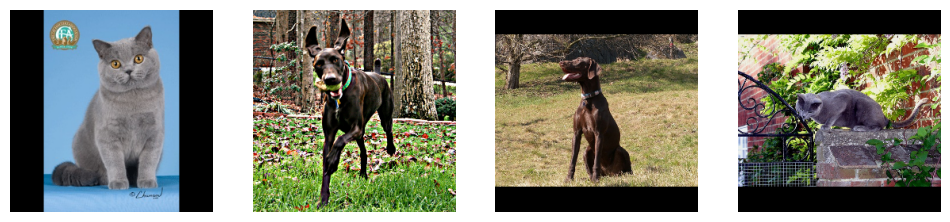

In [20]:
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        # bbox_pred의 형태와 값을 출력
        print(f'bbox_pred shape: {bbox_pred.shape}')
        print(f'bbox_pred: {bbox_pred}')

        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            h, w, _ = img.shape
            # bbox_pred를 반복문에 넣어서 각 박스를 그리도록 합니다.
            if len(bbox_pred.size()) > 1:  # bbox_pred가 0차원 텐서가 아닌 경우만 처리
                for box in bbox_pred[i]:
                    if len(box.size()) == 1 and box.size(0) == 4:  # box가 1차원 텐서이고 크기가 4인 경우만 처리
                        # 예측된 박스 좌표를 이미지 크기에 맞게 조정
                        x1, y1, x2, y2 = box[0].item() * w, box[1].item() * h, box[2].item() * w, box[3].item() * h
                        rect = patches.Rectangle(
                            (x1, y1), x2 - x1, y2 - y1, 
                            linewidth=2, edgecolor='r', facecolor='none'
                        )
                        axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)